# Data Acquisition

In [1]:
### Import required libraries.
import geopandas
import descartes
from descartes import PolygonPatch
import json
import math
import pandas as pd
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import boto3
from datetime import datetime, timezone
import pytz
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib import cm 
from IPython.display import HTML,display,Javascript
from collections import defaultdict
import warnings
#display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings('ignore')


from urllib.request import urlopen, Request

%matplotlib inline


## Loading Dataset


### Download required data sets
* fips2county data. This data will be used cross reference fips codes with county names
* census state cartographic boundary files. This data will be used to draw state boarders for state map using geopandas 
* census county cartographic boundary files. This data will be used to draw county boarders for state map using geopandas 

In [15]:
def download(url: str, dest_folder: str):
    filename = url.split('/')[-1].replace(" ", "_")
    file_path = os.path.join(dest_folder, filename)
    
    if not os.path.exists(file_path):
        os.makedirs(dest_folder, exist_ok=True)
        r = requests.get(url, stream=True)
        if r.ok:
            print("saving to", os.path.abspath(file_path))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
        else:  
            print("Download failed: status code ",r.status_code)
            print(r.text)
        
        
# Download fips data, and load it into data frame
download("https://raw.githubusercontent.com/ChuckConnell/articles/master/fips2county.tsv", dest_folder="./data")
fips_df = pd.read_csv('./data/fips2county.tsv', sep='\t', header='infer', dtype=str, encoding='latin-1')
fips_df=fips_df.set_index('CountyFIPS')
#geo county data
geo_county_df = geopandas.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_5m.zip")
geo_county_df['fipsCode']= geo_county_df['STATEFP']+geo_county_df['COUNTYFP']
#geo state data
geo_state_df = geopandas.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")


### Parse Election

load AP election capture data from the Georgia Senate Election. The results ia dictonary indexed by capture time of election results throught eleciton night. 

* General eleciton capture will be used to train the model
* runnoff election will be used for test data. 

In [16]:
def build_ap_eleciton_data(eleciton_data):
    county_fipps=set(eleciton_data.keys())-set(['metadata','summary'])
    election_data_counties=[eleciton_data[code] for code in county_fipps ]
    df=pd.json_normalize(election_data_counties,'candidates',['fipsCode',
                                                              'precinctsReporting',
                                                              'precinctsTotal',
                                                              'eevp',
                                                              ['parameters','vote','expected','actual'],
                                                              ['parameters','vote','total'],
                                                              ['parameters','vote','registered']])

    
    df['candidateID']=df['candidateID'].apply(lambda x: eleciton_data['metadata']['candidates'][x]['first']+\
                                                        eleciton_data['metadata']['candidates'][x]['last'])
    
    df = df.set_index(['fipsCode','candidateID'])
    return df


def ap_election_from_file(election_dir):
    files = os.listdir(election_dir)
    files = sorted([(f.split('_')[0],f) for f in files if os.path.isfile(election_dir+'/'+f)]) 
    #dictionary indexed by capture time, holds dataframe of county results 
    election_timeseries={}
    #loop through each election capture 
    for epoch, file in files:
        with open(election_dir+file) as f:
            eleciton_data = json.loads(f.read())
        election_timeseries[epoch]=build_ap_eleciton_data(eleciton_data)
    return election_timeseries

def ap_election_from_S3(bucket_name, prefix ):
    s3 = boto3.client('s3')
    resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    files = [ obj['Key']   for obj in resp['Contents']]
    files = sorted(map(lambda file: (file.split('/')[-1].split('_')[0],file), files))
    election_timeseries={}
    for epoch, file in files:
        data=s3.get_object(Bucket=bucket_name, Key=file )
        contents = data['Body'].read()
        eleciton_data = json.loads(contents.decode("utf-8"))
        election_timeseries[epoch]=build_ap_eleciton_data(eleciton_data)
    return election_timeseries


runoff_timeseries=ap_election_from_file('./data/2022/GA/ussenate/runoff/')
election_timeseries=ap_election_from_file('./data/2022/GA/ussenate/general/')


# Exploratory Analysis

## Display Eleciton Data
display sample AP election capture

In [17]:
epochs=list(election_timeseries.keys())
df=election_timeseries[epochs[1]]
df.reset_index()

,fipsCode,candidateID,voteCount,votePct,precinctsReporting,precinctsTotal,eevp,parameters.vote.expected.actual,parameters.vote.total,parameters.vote.registered
0,13235,RaphaelWarnock,0,0,0,1,0,3958,0,5661
1,13235,HerschelWalker,0,0,0,1,0,3958,0,5661
2,13235,ChaseOliver,0,0,0,1,0,3958,0,5661
3,13309,RaphaelWarnock,0,0,0,2,0,2146,0,3153
4,13309,HerschelWalker,0,0,0,2,0,2146,0,3153
...,...,...,...,...,...,...,...,...,...,...
472,13059,HerschelWalker,0,0,0,24,0,48213,0,70727
473,13059,ChaseOliver,0,0,0,24,0,48213,0,70727
474,13175,RaphaelWarnock,0,0,0,15,0,21635,0,32312
475,13175,HerschelWalker,0,0,0,15,0,21635,0,32312



## Display map of county vote change

Generate a time laps map of change in Georgia county results for Raphael Warnock for General election captures as the vote comes in throughout election night

In [20]:
EST = pytz.timezone('US/Eastern')


last_election_capture=election_timeseries[epochs[-1]]
master=pd.merge(geo_county_df,last_election_capture.reset_index().query("candidateID == 'RaphaelWarnock'"), on="fipsCode")

def plot_frame(epoch):
    colors = 'RdBu_r'
    #Create the colormap using the min/max values
    vmin = 0
    vmax = 100
    cmap = cm.ScalarMappable(Normalize(vmin, vmax), colors)
    fig, [ax,cax] = plt.subplots(1, 2, figsize = (10,10), gridspec_kw={"width_ratios":[50,1]})
    #Create the colorbar with colormap
    plt.colorbar(mappable = cmap, cax = cax)
    cax.set_title('Raphael Warnock Vote Pct')

    ax.set_title('Election Night Vote Returns By Time: {}'.format(datetime.fromtimestamp( int(epoch) ).astimezone(EST).isoformat()  ))
    master=pd.merge(geo_county_df,election_timeseries[epoch].reset_index().query("candidateID == 'RaphaelWarnock'"), on="fipsCode")
    geo_state_df.query("NAME == 'Georgia'").plot(ax=ax, edgecolor="black", color="white")
    master.plot(ax=ax, column='votePct',vmin = vmin, vmax=vmax,cmap = colors)
    plt.close()
    return ax, fig
# queue up the captures to where results start coming in
start=0
for idx,epoch in enumerate(epochs):
    if election_timeseries[epoch].reset_index().query("candidateID == 'RaphaelWarnock'")['votePct'].sum()>0:
        start=idx
        break
for idx,epoch in enumerate(epochs[(start-1):]):
     ax, fig = plot_frame(epoch) 
     fig.savefig('./viz/img{:03d}.png'.format(idx), dpi=100, format='png', bbox_inches='tight')

In [21]:
%%bash
cd ./viz;
# Create a gif viz
ffmpeg -y -framerate 12  -i  img%03d.png -f gif out.gif> /dev/null 2>&1



![map_of_county_vote_change](./viz/out.gif)


## Linear Regression Plot 
fist, we'll try to fit a linear model to the vote precentage retuned for each county throughtout election night, then we'll see how good of a fit a general linear model represents the data by examining the residuals of our linear model fit

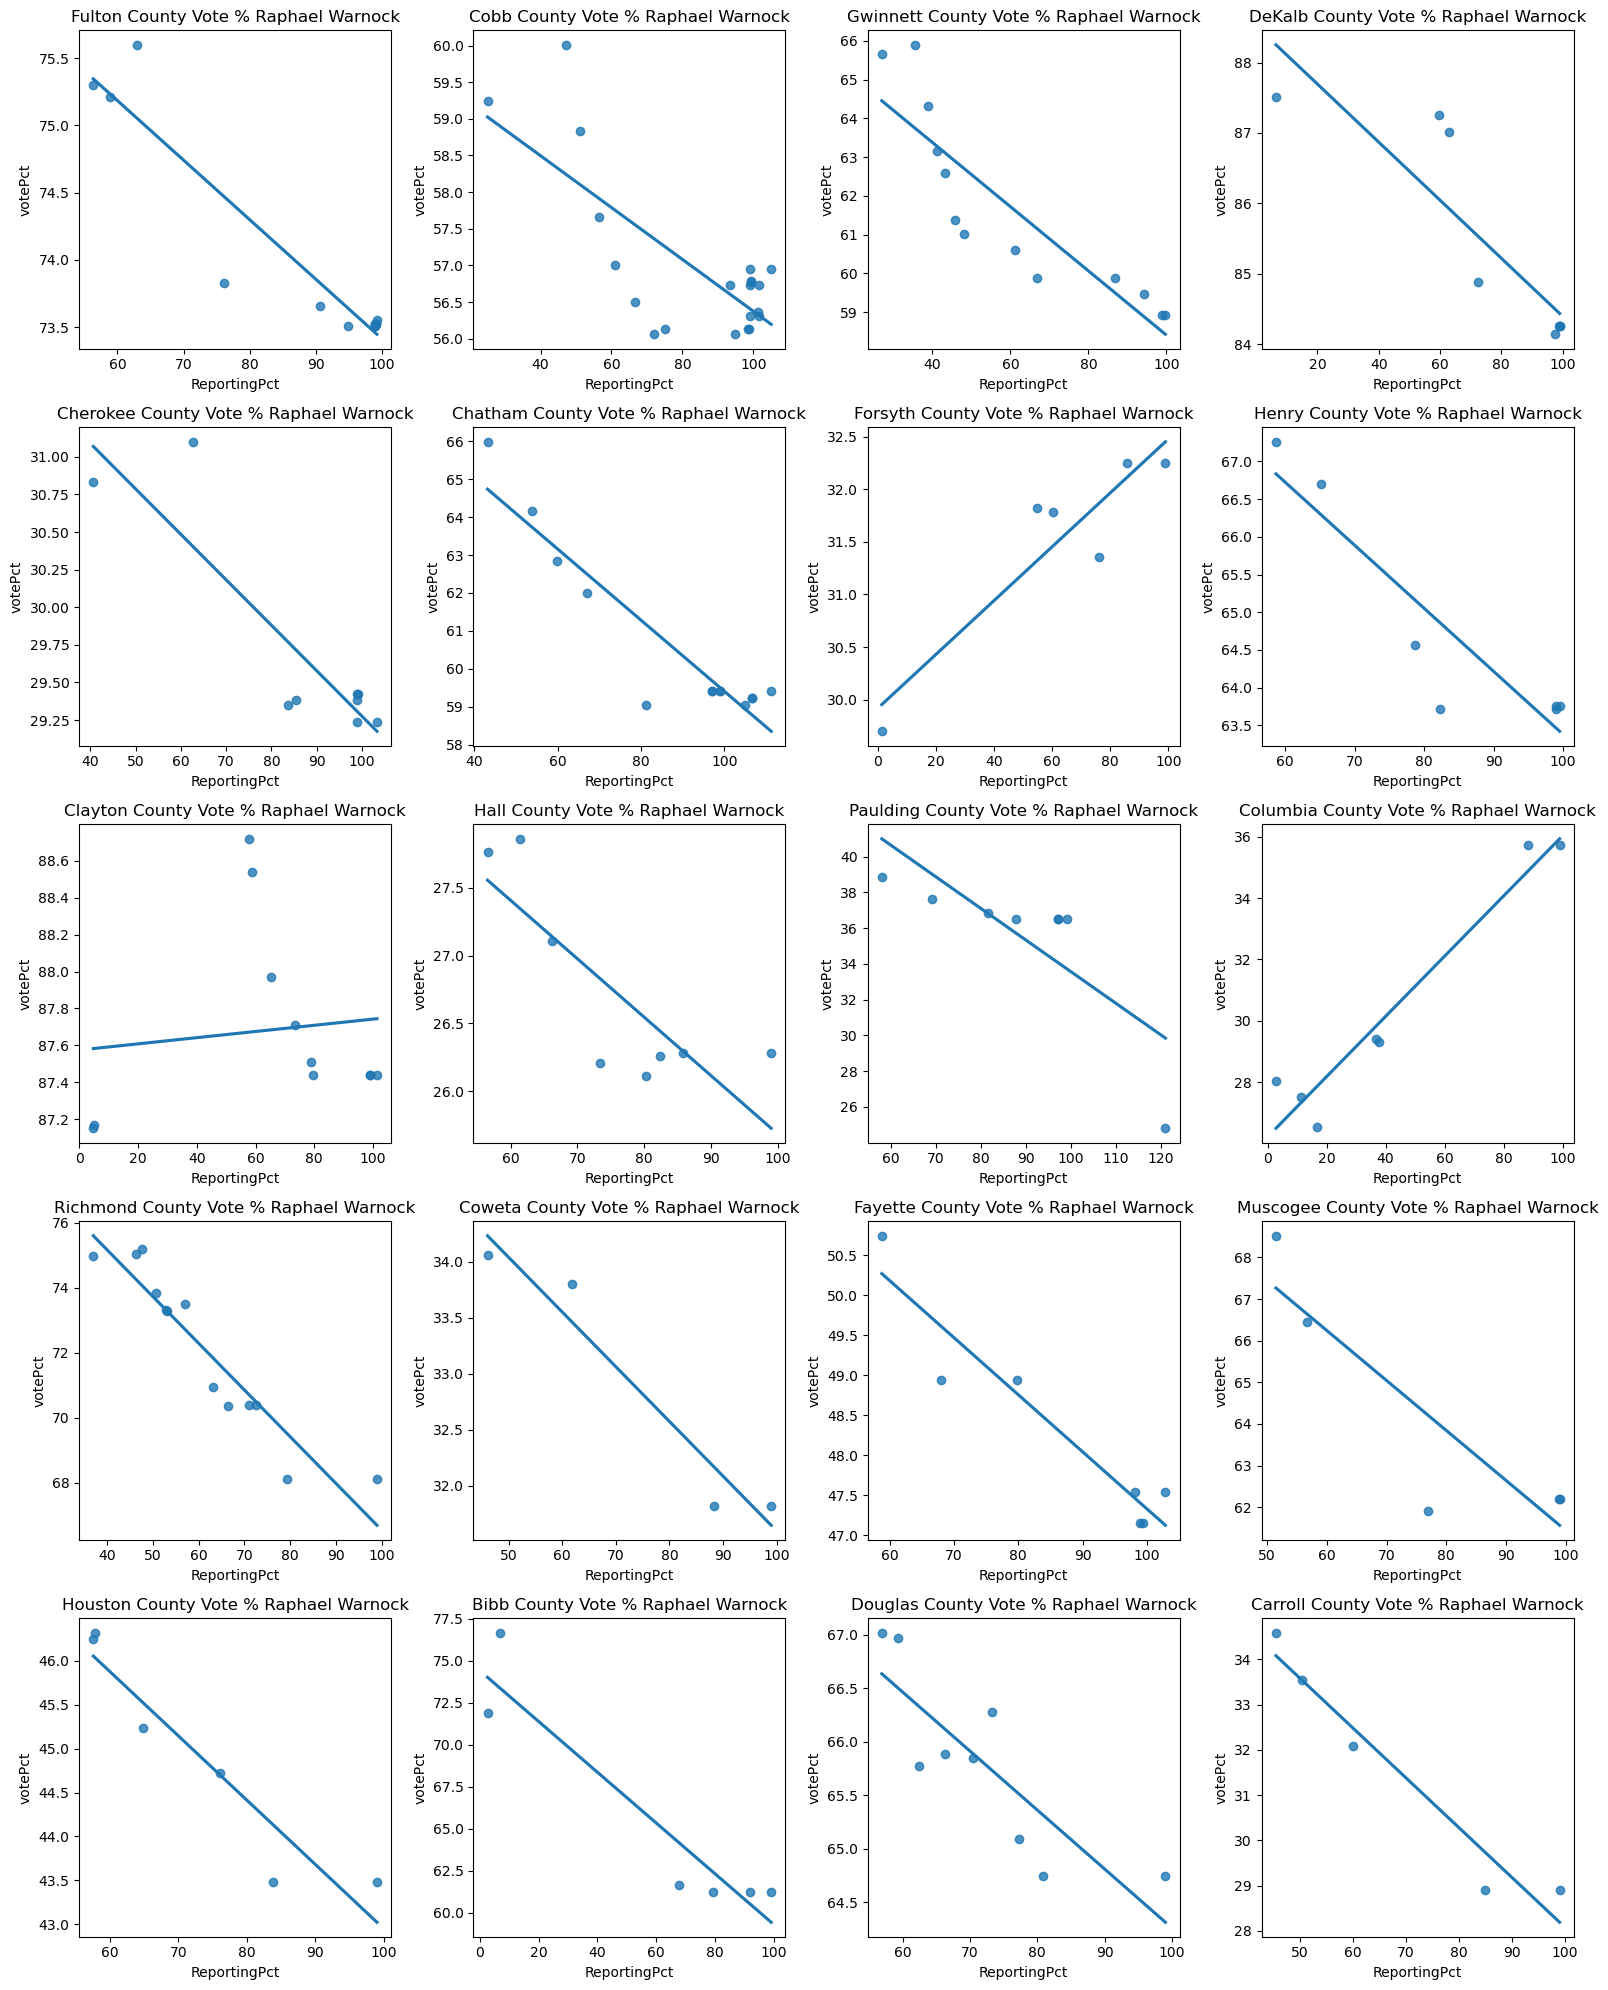

In [22]:
ncol = 4
sorted_vote_count_df=election_timeseries[epochs[-1]].sort_values('parameters.vote.expected.actual', ascending=False)
sorted_vote_count_df=sorted_vote_count_df.xs('RaphaelWarnock', level='candidateID', drop_level=False).reset_index() 
nrow = math.ceil(sorted_vote_count_df['fipsCode'].head(20).shape[0]/ncol)
i = 1
f, axs = plt.subplots( ncols=ncol, nrows=nrow,figsize=( 4.0 * ncol,4.0 * nrow))
axs = axs.flatten()
for ax,fips in zip(axs, sorted_vote_count_df['fipsCode'].head(20)):
    df=pd.concat([election_timeseries[epoch].loc[fips,'RaphaelWarnock'] for epoch in epochs],  axis=1).T
    df=df.reset_index(drop=True)
    df['ReportingPct']=(df['parameters.vote.total']/df['parameters.vote.expected.actual'])*100
    edf=df[0<df['votePct'] ].drop_duplicates()
    order=1
    ax.set_title(fips_df.loc[fips]['CountyName']+' County Vote % Raphael Warnock')
    sns.regplot(x='ReportingPct', y='votePct', data=edf.astype(float), order=order, ci=None,  ax=ax)
    i += 1
plt.tight_layout() 
plt.show()

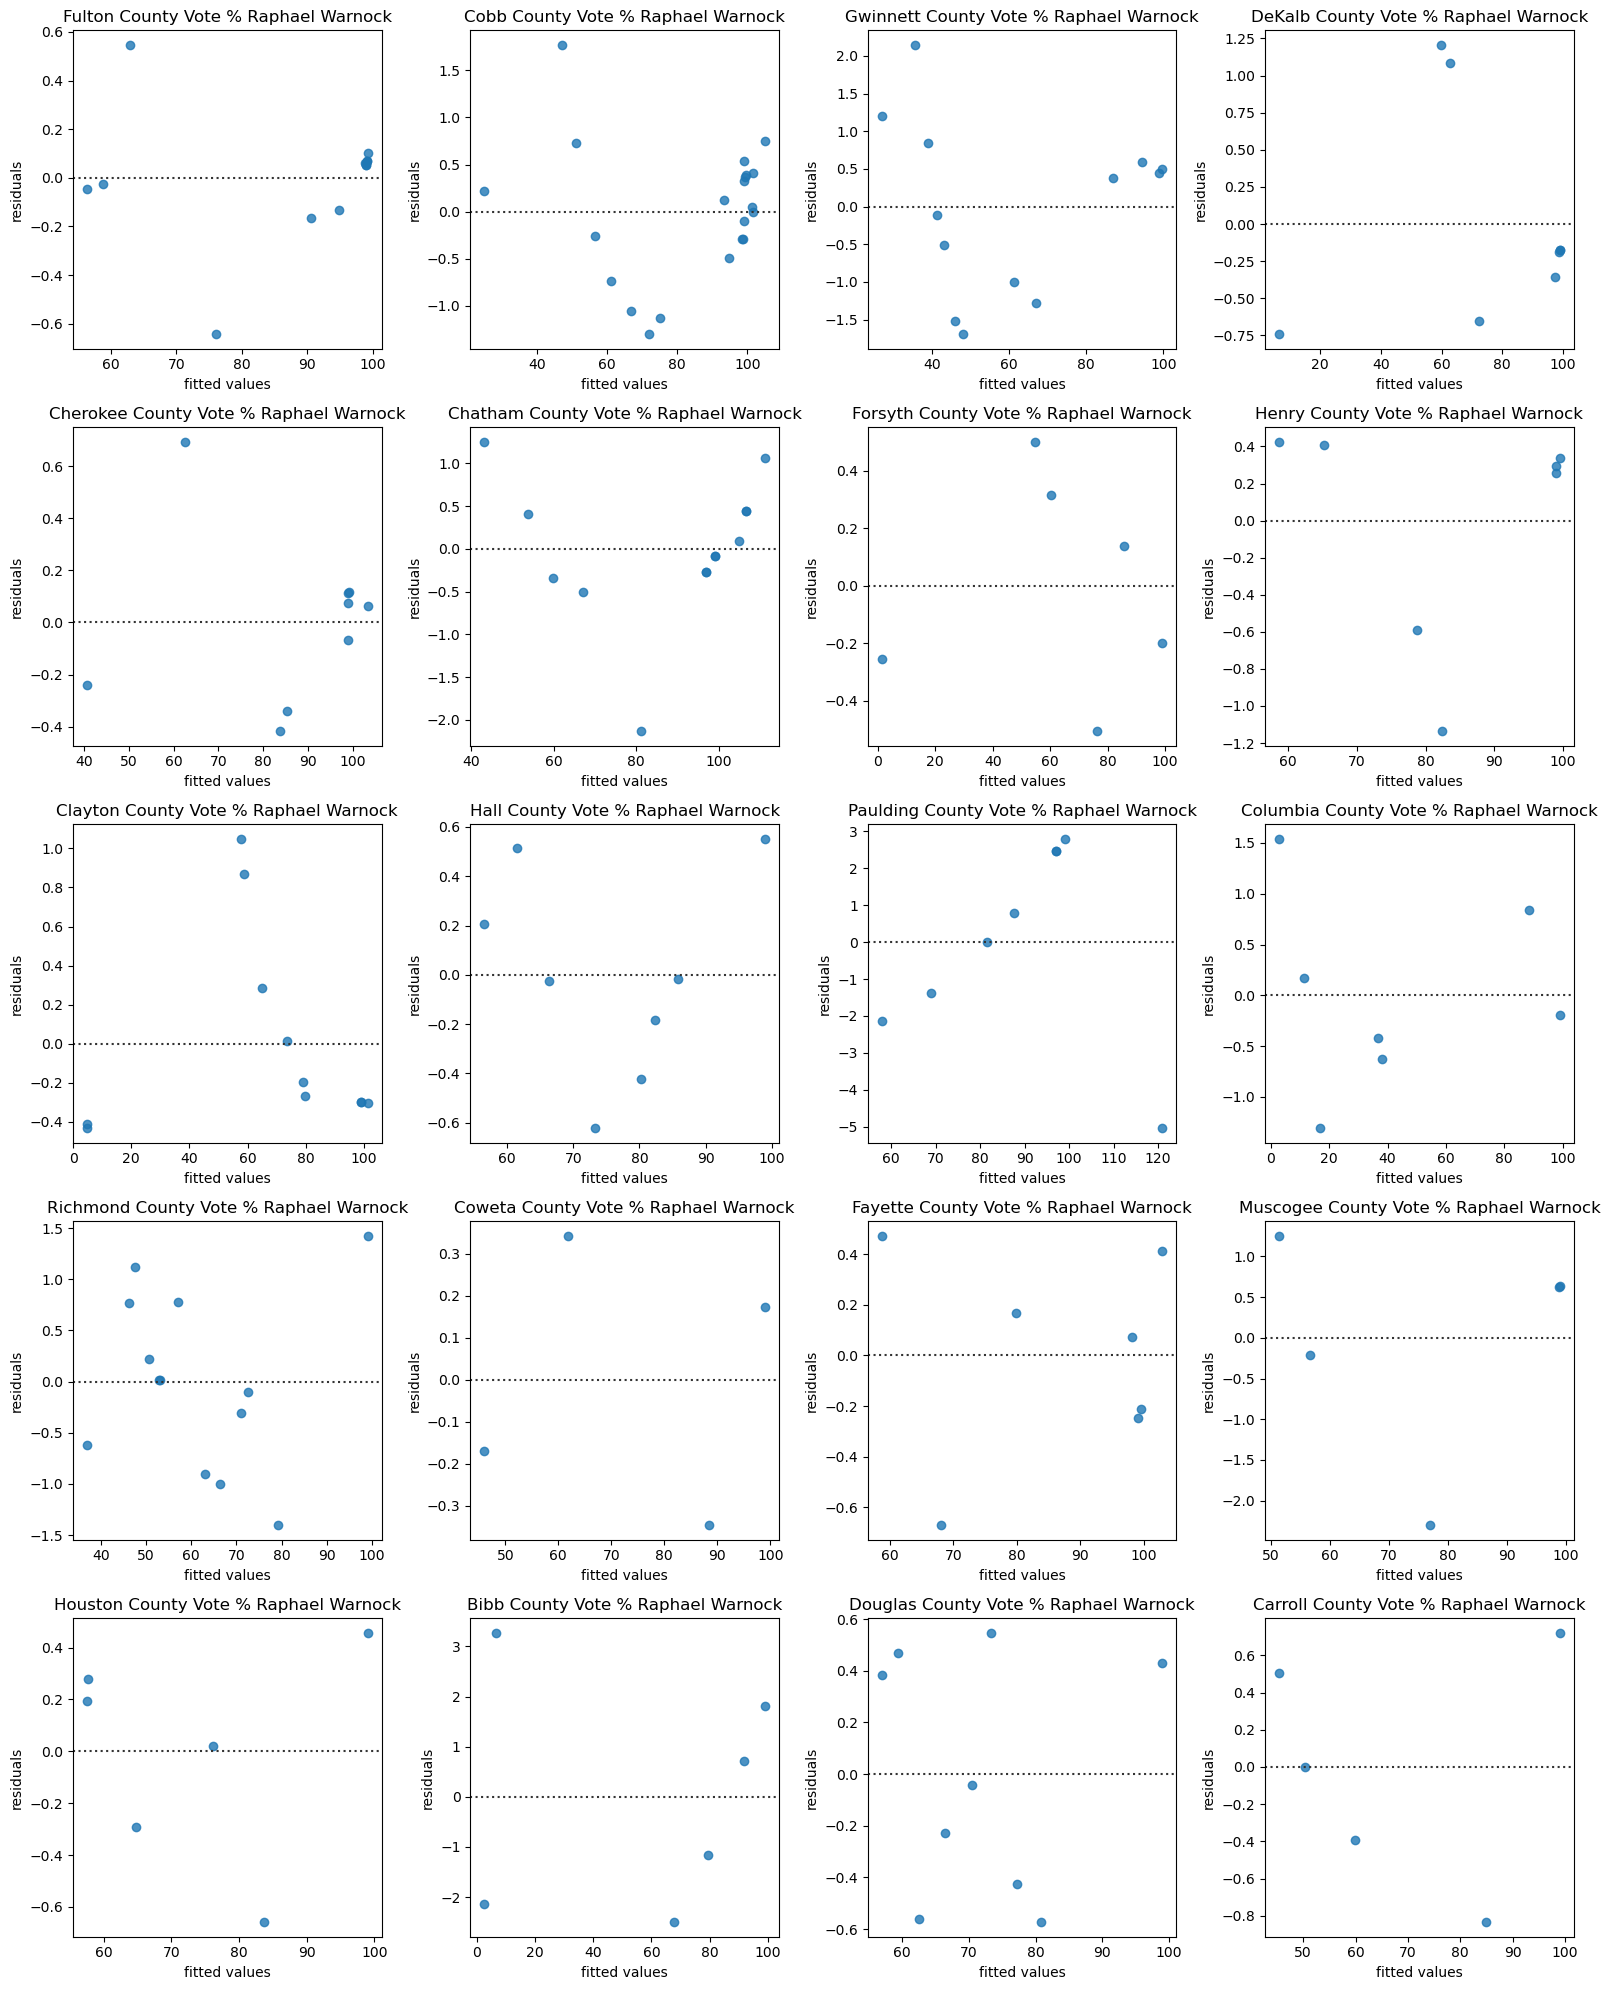

In [23]:
ncol = 4
sorted_vote_count_df=election_timeseries[epochs[-1]].sort_values('parameters.vote.expected.actual', ascending=False)
sorted_vote_count_df=sorted_vote_count_df.xs('RaphaelWarnock', level='candidateID', drop_level=False).reset_index() 
nrow = math.ceil(sorted_vote_count_df['fipsCode'].head(20).shape[0]/ncol)
i = 1
f, axs = plt.subplots( ncols=ncol, nrows=nrow,figsize=( 4.0 * ncol,4.0 * nrow))
axs = axs.flatten()
for ax,fips in zip(axs, sorted_vote_count_df['fipsCode'].head(20)):
    df=pd.concat([election_timeseries[epoch].loc[fips,'RaphaelWarnock'] for epoch in epochs],  axis=1).T
    df=df.reset_index(drop=True)
    df['ReportingPct']=(df['parameters.vote.total']/df['parameters.vote.expected.actual'])*100
    edf=df[0<df['votePct'] ].drop_duplicates()
    order=1
    ax.set_title(fips_df.loc[fips]['CountyName']+' County Vote % Raphael Warnock')

    #sns.regplot(x='ReportingPct', y='votePct', data=edf.astype(float), order=order, ci=None, scatter_kws={"s": 80}, ax=ax)
    sns.residplot(x='ReportingPct', y='votePct', data=edf.astype(float), order=order,  ax=ax)
    ax.set(ylabel='residuals',xlabel='fitted values')

    i += 1
plt.tight_layout() 
plt.show()



## Polynomial Regression Plot 

Perhaps a a polynaomial model is a better fit for the data, so let's plot a  polynomial regression fit to data as well. 

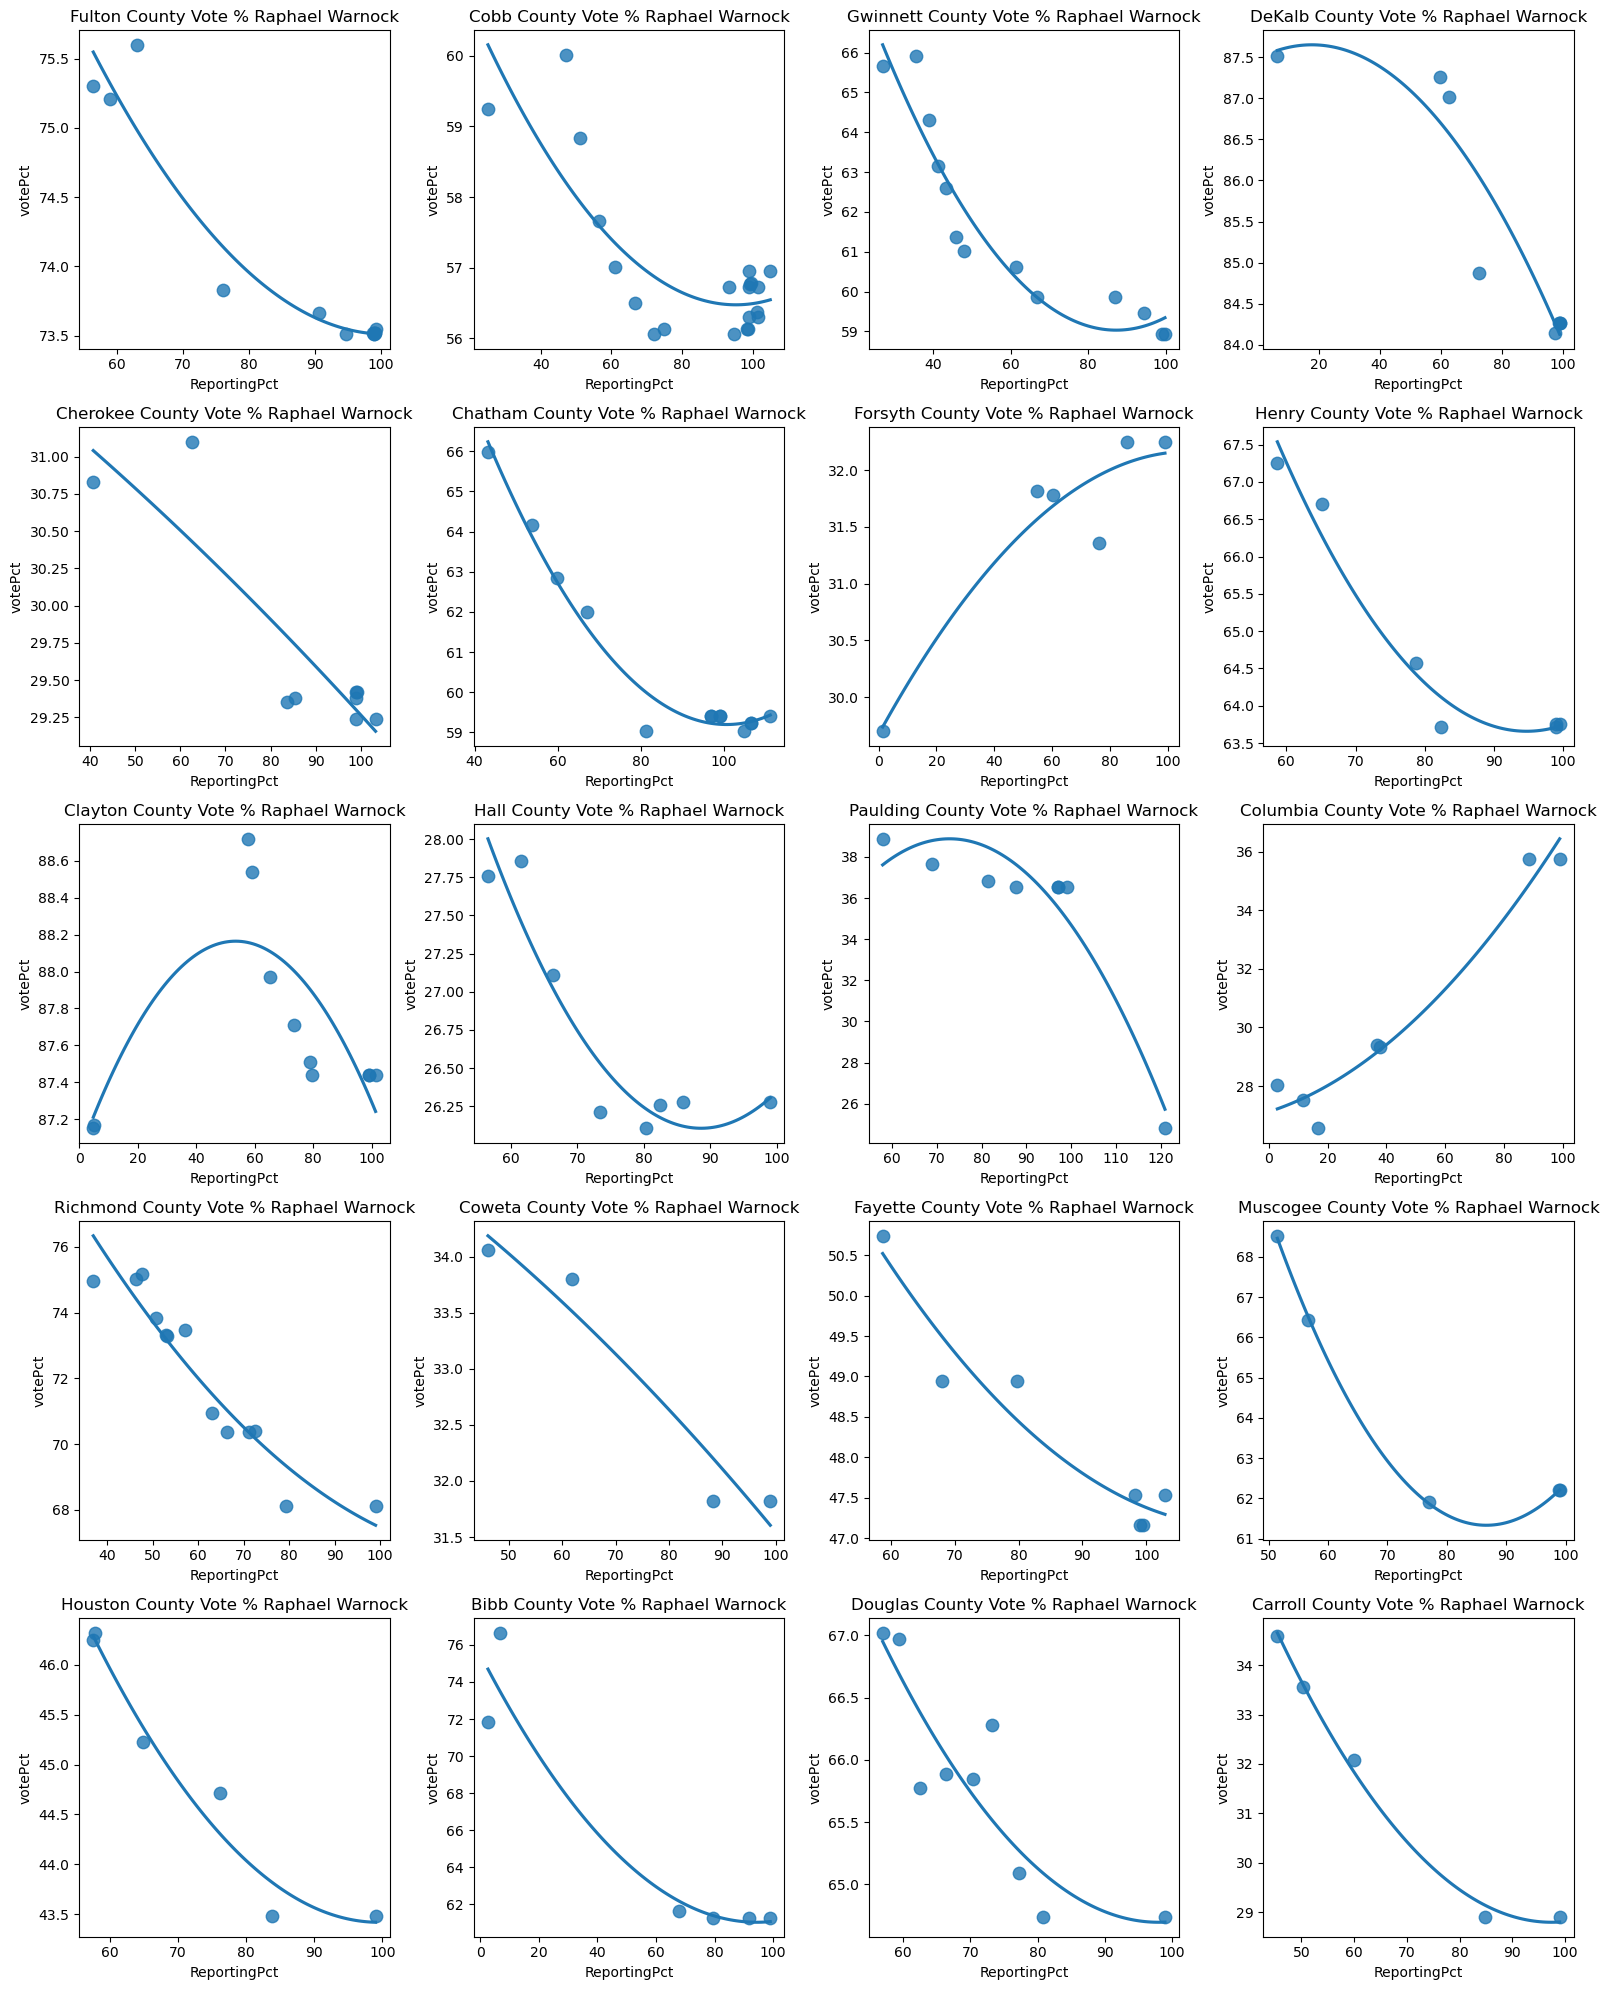

In [24]:
ncol = 4
nrow = math.ceil(sorted_vote_count_df['fipsCode'].head(20).shape[0]/ncol)

i = 1
f, axs = plt.subplots( ncols=ncol, nrows=nrow,figsize=( 4.0 * ncol,4.0 * nrow))
axs = axs.flatten()
for ax,fips in zip(axs, sorted_vote_count_df['fipsCode'].head(20)):
    df=pd.concat([election_timeseries[epoch].loc[fips,'RaphaelWarnock'] for epoch in epochs],  axis=1).T
    df=df.reset_index(drop=True)
    df['ReportingPct']=(df['parameters.vote.total']/df['parameters.vote.expected.actual'])*100
    edf=df[0<df['votePct'] ].drop_duplicates()
    if edf.shape[0]>3:
        order=2
    else:
        order=1
    ax.set_title(fips_df.loc[fips]['CountyName']+' County Vote % Raphael Warnock')

    sns.regplot(x='ReportingPct', y='votePct', data=edf.astype(float), order=order, ci=None, scatter_kws={"s": 80}, ax=ax)
    i += 1
plt.tight_layout() 
plt.show()

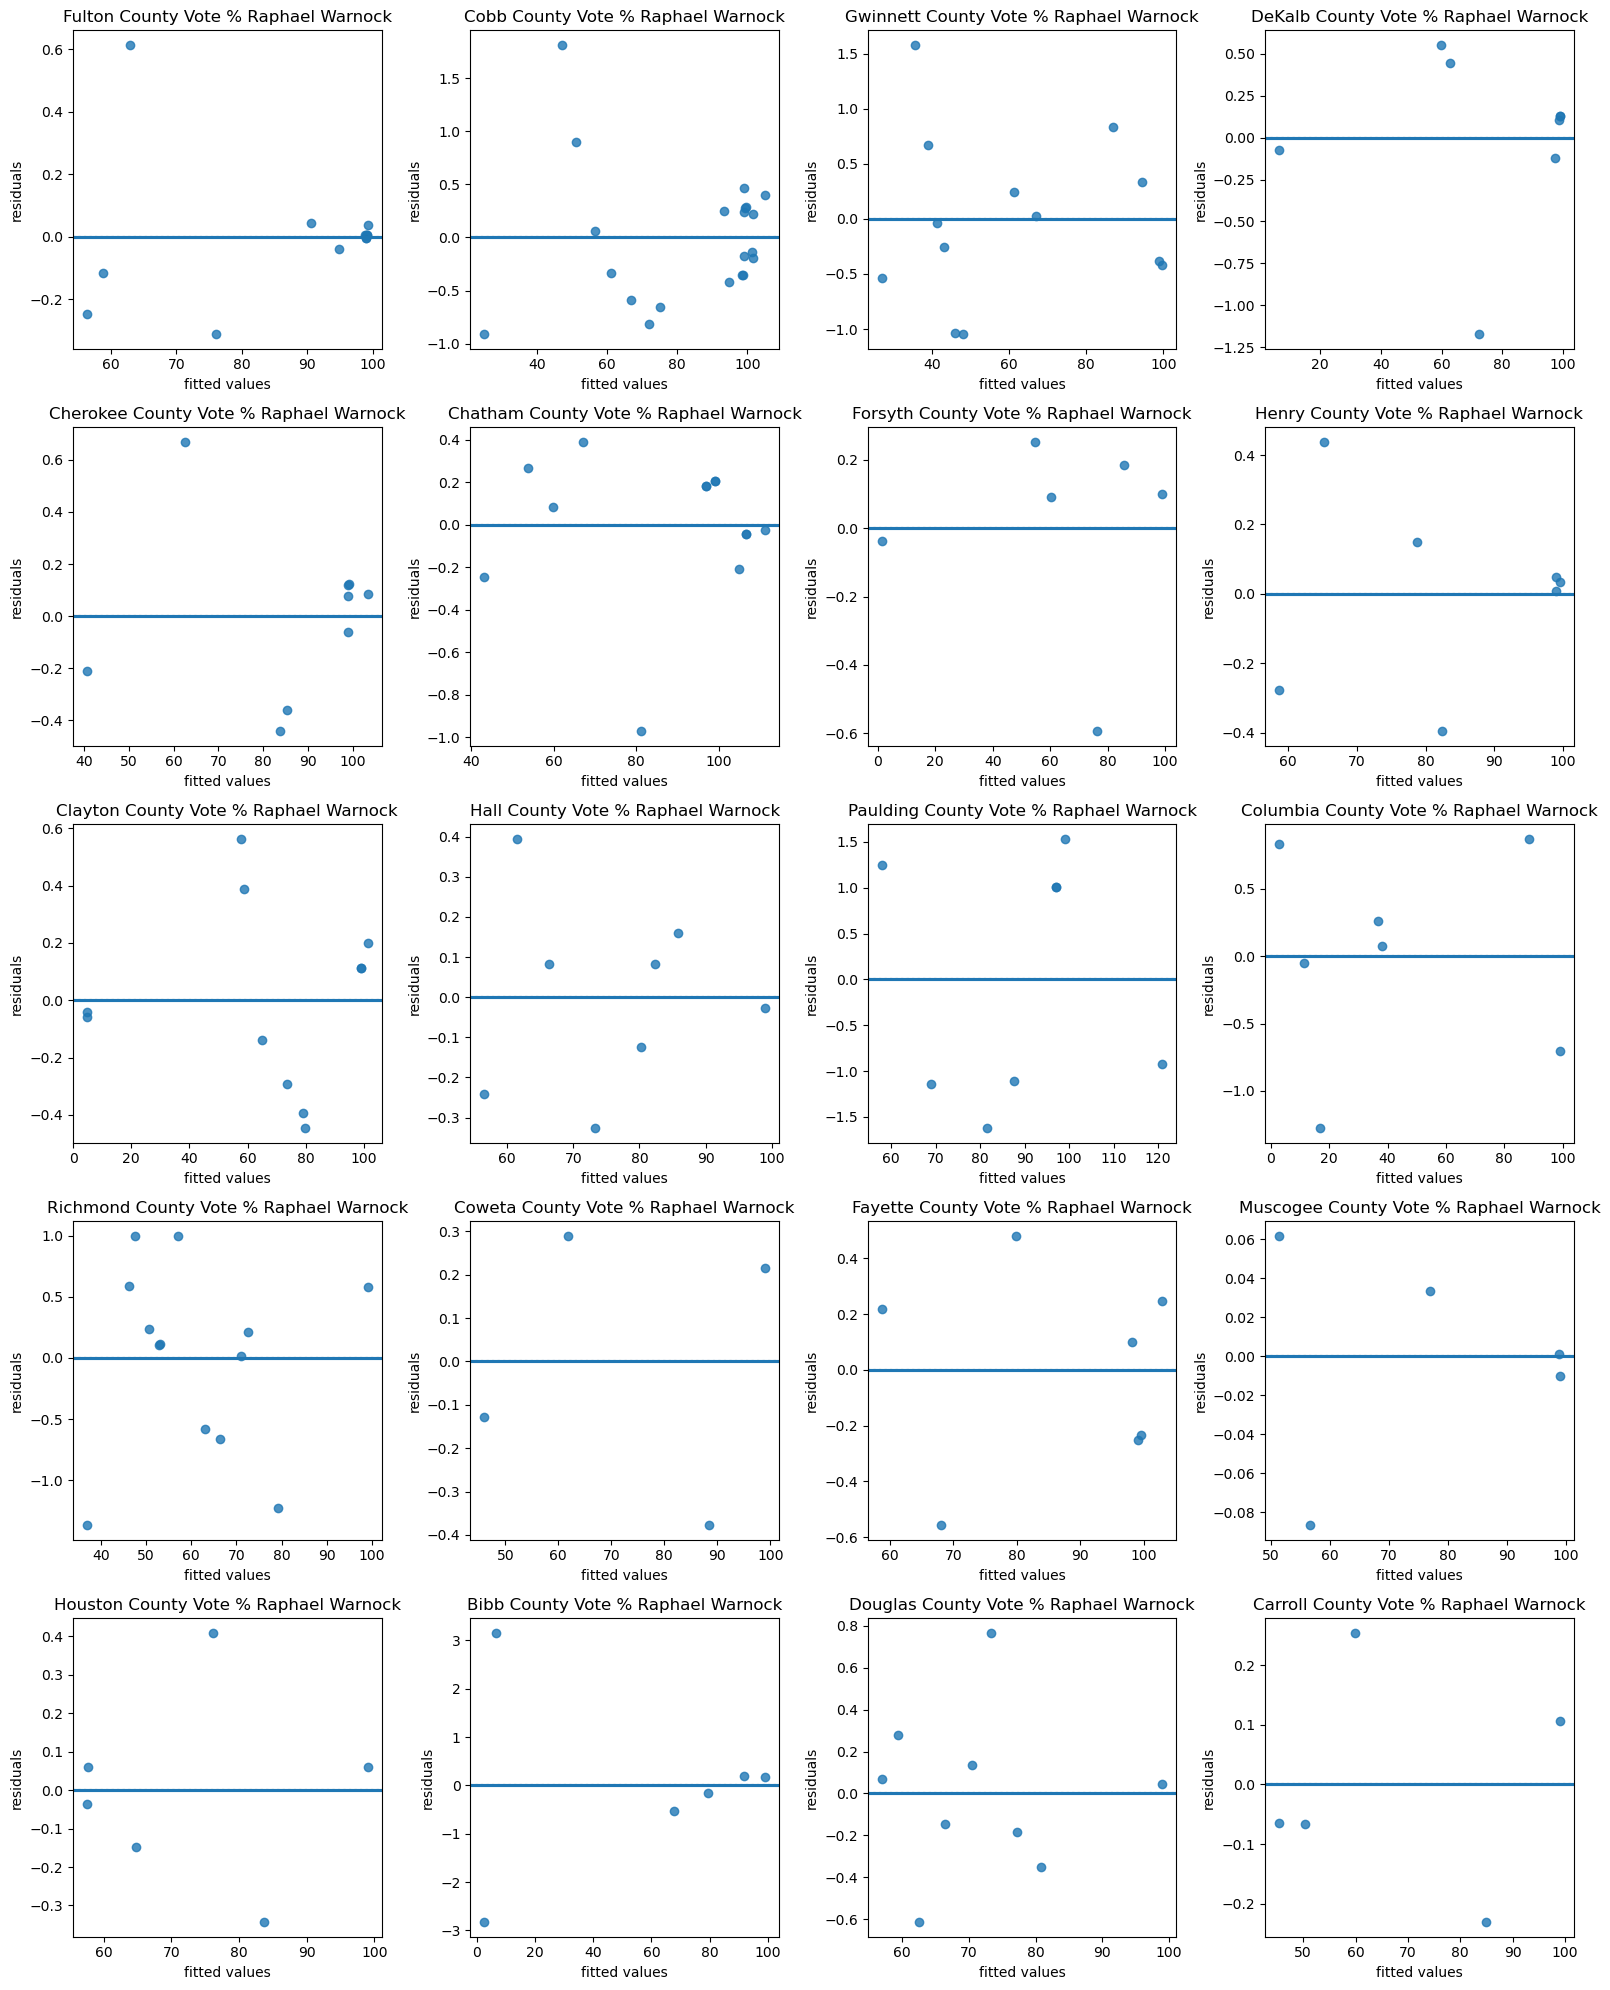

In [25]:
ncol = 4
nrow = math.ceil(sorted_vote_count_df['fipsCode'].head(20).shape[0]/ncol)

i = 1
f, axs = plt.subplots( ncols=ncol, nrows=nrow,figsize=( 4.0 * ncol,4.0 * nrow))
axs = axs.flatten()
for ax,fips in zip(axs, sorted_vote_count_df['fipsCode'].head(20)):
    df=pd.concat([election_timeseries[epoch].loc[fips,'RaphaelWarnock'] for epoch in epochs],  axis=1).T
    df=df.reset_index(drop=True)
    df['ReportingPct']=(df['parameters.vote.total']/df['parameters.vote.expected.actual'])*100
    edf=df[0<df['votePct'] ].drop_duplicates()
    if edf.shape[0]>3:
        order=2
    else:
        order=1

    ax.set_title(fips_df.loc[fips]['CountyName']+' County Vote % Raphael Warnock')

    sns.residplot(x='ReportingPct', y='votePct', data=edf.astype(float), order=order,  lowess=True, ax=ax)
    ax.set(ylabel='residuals',xlabel='fitted values')
    i += 1
plt.tight_layout() 
plt.show()



# Fitting Model

Before we fit our model, let's get a baseline error without any adjustment. This would be the RMSD between the count of an election capture throughout election night and the final result in a county. 

In [26]:
def RMSD(dfp,dfx):
    return(((dfp - dfx) ** 2).mean() ** .5)
runoff_epoch_keys=list(runoff_timeseries.keys())
last_election_capture_runoff=runoff_timeseries[runoff_epoch_keys[-1]]
true_result=last_election_capture_runoff.xs('RaphaelWarnock', level='candidateID')['voteCount'].sum()/last_election_capture_runoff['voteCount'].sum()

general_epochs=list(election_timeseries.keys())
last_election_capture=election_timeseries[general_epochs[-1]]

error=0
for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    runoff_indexes=df[df['eevp']>10].index
    if len(runoff_indexes):
        adjusted_eevp_df= df.loc[runoff_indexes]['votePct']
        vote_count=df.loc[runoff_indexes]['parameters.vote.expected.actual']*adjusted_eevp_df/100
        error+= RMSD(vote_count.xs('RaphaelWarnock', level='candidateID'),last_election_capture_runoff.loc[runoff_indexes].xs('RaphaelWarnock', level='candidateID')['voteCount']) 
print(f'Cumulative baseline error of Raphael Warnock\'s margins in the runoff election {error=}')

Cumulative baseline error of Raphael Warnock's margins in the runoff election error=939503.08909289


## 1. Linear Regression
We use the 2022 georgia general election to build our linear regression model

In [27]:
class Election_Model():
    def __init__(self,model,*model_list_args,**model_dict_args):
        def default_value():
            return model(*model_list_args,**model_dict_args)
        def default_index():
            return defaultdict(default_value)
         
        self.election_model_dict= defaultdict(default_index)

    def __getitem__(self, index):
        return self.election_model_dict[index]

        
    

linear_model = Election_Model(LinearRegression);


for fips in last_election_capture.reset_index()['fipsCode'].unique():
    for candidate_id in last_election_capture.loc[fips].index:

        df=pd.concat([election_timeseries[epoch].loc[fips,candidate_id] for epoch in general_epochs],  axis=1).T
        df=df.reset_index(drop=True)
        df['ReportingPct']=(df['parameters.vote.total']/df['parameters.vote.expected.actual'])*100
        edf=df[0<df['votePct'] ].drop_duplicates()

        x = np.array([edf['ReportingPct'].array.astype(float)]).T
        y = np.array([edf['votePct'].array.astype(float)]).T

        linear_model[fips][candidate_id].fit(x, y)



test our linear model with data from the 2022 georgia runoff eleciton 

In [28]:

error=0
for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    runoff_indexes=df[df['eevp']>10].index
    if len(runoff_indexes):
        adjusted_eevp_df=np.array([ linear_model[fips][candidate_id].predict(np.array([[100]]))[0][0]- linear_model[fips][candidate_id].predict(np.array([[ df.loc[fips, candidate_id]['eevp']  ]]))[0][0] for fips, candidate_id in runoff_indexes])  + df.loc[runoff_indexes]['votePct']
        vote_count=df.loc[runoff_indexes]['parameters.vote.expected.actual']*adjusted_eevp_df/100
        error+= RMSD(vote_count.xs('RaphaelWarnock', level='candidateID'),last_election_capture_runoff.loc[runoff_indexes].xs('RaphaelWarnock', level='candidateID')['voteCount']) 
print(f'Cumulative simple regression error of Raphael Warnock\'s margins in the runoff election {error=}')

Cumulative simple regression error of Raphael Warnock's margins in the runoff election error=723365.5316531633


## 2. Polynomial Regression

We use the 2022 georgia general election to build our polynomial regression model

In [29]:
poly_model = Election_Model(LinearRegression);
poly = PolynomialFeatures(2)



for fips in last_election_capture.reset_index()['fipsCode'].unique():
    for candidate_id in last_election_capture.loc[fips].index:

        
        
        df=pd.concat([election_timeseries[epoch].loc[fips,candidate_id] for epoch in general_epochs],  axis=1).T
        df=df.reset_index(drop=True)
        df['ReportingPct']=(df['parameters.vote.total']/df['parameters.vote.expected.actual'])*100
        edf=df[0<df['votePct'] ].drop_duplicates()
 
        x = np.array([edf['ReportingPct'].array.astype(float)]).T
        x = poly.fit_transform(x)
        y = np.array([edf['votePct'].array.astype(float)]).T

        poly_model[fips][candidate_id].fit(x, y)

test our polynomial model with data from the 2022 georgia runoff eleciton 

In [30]:
error=0
poly = PolynomialFeatures(2)

for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    runoff_indexes=df[df['eevp']>10].index
    if len(runoff_indexes):
        adjusted_eevp_df=np.array([ poly_model[fips][candidate_id].predict(  poly.fit_transform( np.array([[100]]) ))[0][0]- poly_model[fips][candidate_id].predict(  poly.fit_transform( np.array([[ df.loc[fips, candidate_id]['eevp']  ]]) )   )[0][0] for fips, candidate_id in runoff_indexes])  + df.loc[runoff_indexes]['votePct']
        vote_count=df.loc[runoff_indexes]['parameters.vote.expected.actual']*adjusted_eevp_df/100
        error+= RMSD(vote_count.xs('RaphaelWarnock', level='candidateID'),last_election_capture_runoff.loc[runoff_indexes].xs('RaphaelWarnock', level='candidateID')['voteCount']) 
 
print(f'Cumulative polynomial regression  error of Raphael Warnock\'s margins in the runoff election {error=}')

Cumulative polynomial regression  error of Raphael Warnock's margins in the runoff election error=732958.2334045434


# Conclusion

In this exercise, our goal was to build an election night margin prediction model. As results come in throughout election night, early results are usually skewed based on voting patterns. Early in-person and mail-in votes are usually counted first, election day votes are counted after, and as the data shows, most counties trend democrat early, and progressively get more republican as counting continues. Throughout election night, our ideal model would adjust the percentage reported so-far to match the final result, and any deviation from the final results is error. Our cumulative baseline root-squared-error without any adjustment was  939503. With a simple linear model our error improved to 723365, but the residuals showed that the data might benefit from polynomial adjustment, this however produced worse results in practice. Our polynomial model's error worsened to 732958, perhaps due to overfitting, so a linear model worked best for predicting the election night margins for the Georgia runoff election.

* Cumulative baseline error 939503.0890928901
* Cumulative simple regression error 723365.5316531633
* Cumulative polynomial regression error 732958.2334045434